In [1]:
import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding, ImageShowCV2
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen
from mltu.annotations.images import CVImage

from mltu.tensorflow.dataProvider import DataProvider
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CWERMetric

import os
import tarfile
from tqdm import tqdm
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

2024-11-11 01:46:02.228413: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731269762.327238      96 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731269762.355013      96 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 01:46:02.606812: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from datetime import datetime

from mltu.configs import BaseModelConfigs

class ModelConfigs(BaseModelConfigs):
    def __init__(self):
        super().__init__()
        self.model_path = os.path.join("Models/LSTM", datetime.strftime(datetime.now(), "%Y%m%d%H%M"))
        self.vocab = ""
        self.height = 32
        self.width = 128
        self.max_text_length = 0
        self.batch_size = 16
        self.learning_rate = 0.001
        self.train_epochs = 30
        self.train_workers = 20

In [3]:
from keras import layers
from keras.models import Model

def train_model(input_dim, output_dim, activation="leaky_relu", dropout=0.2):
    
    inputs = layers.Input(shape=input_dim, name="input")

    # Normalize images here instead of preprocessing step
    x = layers.Lambda(lambda x: x / 255)(inputs)

    x = layers.Conv2D(16, (3, 3), activation=activation, padding="same", strides=1)(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv2D(16, (3, 3), activation=activation, padding="same", strides=2)(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Conv2D(32, (3, 3), activation=activation, padding="same", strides=2)(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Conv2D(64, (3, 3), activation=activation, padding="same", strides=2)(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv2D(64, (3, 3), activation=activation, padding="same", strides=1)(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Conv2D(64, (3, 3), activation=activation, padding="same", strides=1)(x)
    x = layers.Dropout(dropout)(x)

    # Reshape the output for LSTM layers
    squeezed = layers.Reshape((x.shape[-3] * x.shape[-2], x.shape[-1]))(x)

    lstm = layers.LSTM(128, return_sequences=True)(squeezed)
    lstm = layers.Dropout(dropout)(lstm)

    output = layers.Dense(output_dim + 1, activation="softmax", name="output")(lstm)

    model = Model(inputs=inputs, outputs=output)
    return model

In [4]:
def download_and_unzip(url, extract_to="Datasets", chunk_size=1024*1024):
    http_response = urlopen(url)

    data = b""
    iterations = http_response.length // chunk_size + 1
    for _ in tqdm(range(iterations)):
        data += http_response.read(chunk_size)

    zipfile = ZipFile(BytesIO(data))
    zipfile.extractall(path=extract_to)

dataset_path = os.path.join("Datasets", "IAM_Words")
if not os.path.exists(dataset_path):
    download_and_unzip("https://git.io/J0fjL", extract_to="Datasets")

    file = tarfile.open(os.path.join(dataset_path, "words.tgz"))
    file.extractall(os.path.join(dataset_path, "words"))

dataset, vocab, max_len = [], set(), 0

In [5]:
# Preprocess the dataset by the specific IAM_Words dataset file structure
words = open(os.path.join(dataset_path, "words.txt"), "r").readlines()
for line in tqdm(words):
    if line.startswith("#"):
        continue

    line_split = line.split(" ")
    if line_split[1] == "err":
        continue

    folder1 = line_split[0][:3]
    folder2 = "-".join(line_split[0].split("-")[:2])
    file_name = line_split[0] + ".png"
    label = line_split[-1].rstrip("\n")

    rel_path = os.path.join(dataset_path, "words", folder1, folder2, file_name)
    if not os.path.exists(rel_path):
        print(f"File not found: {rel_path}")
        continue

    dataset.append([rel_path, label])
    vocab.update(list(label))
    max_len = max(max_len, len(label))

100%|██████████████████████████████████████████████████████████████████████████| 115338/115338 [02:48<00:00, 684.13it/s]


In [6]:
# Create a ModelConfigs object to store model configurations
configs = ModelConfigs()

# Save vocab and maximum text length to configs
configs.vocab = "".join(vocab)
configs.max_text_length = max_len
configs.save()

# Create a data provider for the dataset
data_provider = DataProvider(
    dataset=dataset,
    skip_validation=True,
    batch_size=configs.batch_size,
    data_preprocessors=[ImageReader(CVImage)],
    transformers=[
        ImageResizer(configs.width, configs.height, keep_aspect_ratio=False),
        LabelIndexer(configs.vocab),
        LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
)

In [7]:
# Split the dataset into training and validation sets
train_data_provider_1, val_data_provider_1 = data_provider.split(split = 0.6)
train_data_provider, val_data_provider = val_data_provider_1.split(split = 0.85)

In [8]:
# Augment training data with random brightness, rotation and erode/dilate
train_data_provider.augmentors = [
    RandomBrightness(), 
    RandomErodeDilate(),
    RandomSharpen(),
    RandomRotate(angle=10), 
    ]

In [9]:
# Creating TensorFlow model architecture
model = train_model(
    input_dim = (configs.height, configs.width, 3),
    output_dim = len(configs.vocab),
)

I0000 00:00:1731269991.797696      96 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4080 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


In [10]:
# Compile the model and print summary
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=configs.learning_rate), 
    loss=CTCloss(), 
    metrics=[CWERMetric(padding_token=len(configs.vocab))],
)
model.summary(line_length=110)

# Print all available metrics
print("Available Metrics:", model.metrics_names)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                             │ (None, 32, 128, 3)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ lambda (Lambda)                                │ (None, 32, 128, 3)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv2d (Conv2D)                                │ (None, 32, 128, 16)                 │                 448 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout (Dropout)                              │ (None, 32, 128, 16)                 │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv2d_1 (Conv2D)                              │ (None, 16, 64, 16)                  │               2,320 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_1 (Dropout)                            │ (None, 16, 64, 16)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv2d_2 (Conv2D)                              │ (None, 8, 32, 32)                   │               4,640 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_2 (Dropout)                            │ (None, 8, 32, 32)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv2d_3 (Conv2D)                              │ (None, 4, 16, 64)                   │              18,496 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_3 (Dropout)                            │ (None, 4, 16, 64)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv2d_4 (Conv2D)                              │ (None, 4, 16, 64)                   │              36,928 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_4 (Dropout)                            │ (None, 4, 16, 64)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv2d_5 (Conv2D)                              │ (None, 4, 16, 64)                   │              36,928 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_5 (Dropout)                            │ (None, 4, 16, 64)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ reshape (Reshape)                              │ (None, 64, 64)                      │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ lstm (LSTM)                                    │ (None, 64, 128)                     │              98,816 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_6 (Dropout)                            │ (None, 64, 128)                     │                   0 │
├───

 Total params: 208,767 (815.50 KB)

 Trainable params: 208,767 (815.50 KB)

 Non-trainable params: 0 (0.00 B)

Available Metrics: ['loss', 'compile_metrics']


In [14]:
import matplotlib.pyplot as plt
from keras.callbacks import Callback

class TrainingPlotCallback(Callback):
    def on_train_begin(self, logs=None):
        self.loss = []
        self.cer = []
        self.wer = []
        self.val_loss = []
        self.val_cer = []
        self.val_wer = []
        
    def on_epoch_end(self, epoch, logs=None):
        self.loss.append(logs.get('loss'))
        self.cer.append(logs.get('CER'))
        self.wer.append(logs.get('WER'))
        self.val_loss.append(logs.get('val_loss'))
        self.val_cer.append(logs.get('val_CER'))
        self.val_wer.append(logs.get('val_WER'))
        
    def on_train_end(self, logs=None):
        epochs = range(1, len(self.loss) + 1)

        # Plotting training and validation loss
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.plot(epochs, self.loss, 'b-', label='Training Loss')
        plt.plot(epochs, self.val_loss, 'r-', label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plotting CER
        plt.subplot(1, 3, 2)
        plt.plot(epochs, self.cer, 'b-', label='Training CER')
        plt.plot(epochs, self.val_cer, 'r-', label='Validation CER')
        plt.title('Character Error Rate (CER)')
        plt.xlabel('Epochs')
        plt.ylabel('CER')
        plt.legend()

        # Plotting WER
        plt.subplot(1, 3, 3)
        plt.plot(epochs, self.wer, 'b-', label='Training WER')
        plt.plot(epochs, self.val_wer, 'r-', label='Validation WER')
        plt.title('Word Error Rate (WER)')
        plt.xlabel('Epochs')
        plt.ylabel('WER')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [15]:
# Define callbacks
earlystopper = EarlyStopping(monitor="val_CER", patience=20, verbose=1, mode = 'min')
checkpoint = ModelCheckpoint(f"{configs.model_path}/model.keras", monitor="val_CER", verbose=1, save_best_only=True, mode="min")
trainLogger = TrainLogger(configs.model_path)

tb_callback = TensorBoard(f"{configs.model_path}/logs", update_freq=1)
reduceLROnPlat = ReduceLROnPlateau(monitor="val_CER", factor=0.9, min_delta=1e-10, patience=10, verbose=1, mode="auto")
model2onnx = Model2onnx(f"{configs.model_path}/model.keras")
training_plot_callback = TrainingPlotCallback()

Epoch 1/30
2050/2050 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - CER: 0.9426 - WER: 0.9742 - loss: 13.6299
Epoch 1: val_CER improved from inf to 0.91050, saving model to Models/LSTM/202411110149/model.keras
2050/2050 ━━━━━━━━━━━━━━━━━━━━ 421s 206ms/step - CER: 0.9426 - WER: 0.9742 - loss: 13.6297 - val_CER: 0.9105 - val_WER: 0.9586 - val_loss: 12.1414 - learning_rate: 0.0010
Epoch 2/30
2050/2050 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - CER: 0.8927 - WER: 0.9510 - loss: 12.4807
Epoch 2: val_CER improved from 0.91050 to 0.86504, saving model to Models/LSTM/202411110149/model.keras
2050/2050 ━━━━━━━━━━━━━━━━━━━━ 433s 211ms/step - CER: 0.8927 - WER: 0.9510 - loss: 12.4805 - val_CER: 0.8650 - val_WER: 0.9388 - val_loss: 11.0678 - learning_rate: 0.0010
Epoch 3/30
2050/2050 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - CER: 0.8479 - WER: 0.9317 - loss: 11.5859
Epoch 3: val_CER improved from 0.86504 to 0.82468, saving model to Models/LSTM/202411110149/model.keras
2050/2050 ━━━━━━━━━━━━━━━━━━━━ 430s 210ms/step - C

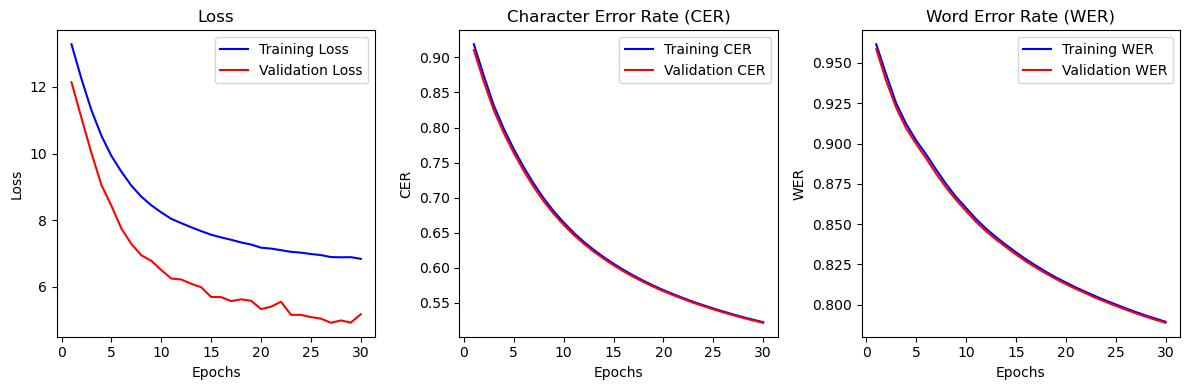

In [16]:
# Train the model
model.fit(
    train_data_provider,
    validation_data=val_data_provider,
    epochs=configs.train_epochs,
    callbacks=[earlystopper, checkpoint, trainLogger, reduceLROnPlat, tb_callback, model2onnx, training_plot_callback],
)